In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import glob
import os
import sklearn.model_selection


## Metadata Preprocessing

We begin by loading and cleaning the metadata. This includes selecting relevant columns, encoding categorical variables (`sex` and `diagnosis_1`), and handling missing values by imputing with the mean. We also create a new `filename` column to match image files with metadata.

In [2]:

metadata = pd.read_csv('metadata.csv')
metadata = metadata[['isic_id','age_approx','clin_size_long_diam_mm','sex','diagnosis_1']]
# encode columns
metadata['sex'] = metadata['sex'].map({'male': 0, 'female': 1})
metadata['diagnosis_1'] = metadata['diagnosis_1'].map({'Benign': 0, 'Malignant': 1})

# missing values
metadata['age_approx'] = metadata['age_approx'].fillna(metadata['age_approx'].mean())
metadata['clin_size_long_diam_mm'] = metadata['clin_size_long_diam_mm'].fillna(metadata['clin_size_long_diam_mm'].mean())
metadata = metadata.dropna()

# Create filename field
metadata['filename'] = metadata['isic_id'].astype(str) + '.jpg'


/var/folders/0b/33n254b510726mq07nrfcfbw0000gn/T/ipykernel_17444/695260491.py:1: DtypeWarning: Columns (6,9,10,11,13,14,15,16,17,18,19,22,23,25,26,27,28,30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('metadata.csv')


In [3]:
benign_df = metadata[metadata['diagnosis_1'] == 0]
malignant_df = metadata[metadata['diagnosis_1'] == 1]

benign_downsampled = benign_df.sample(
    n=len(malignant_df),
    random_state=42,
    replace=False
)

metadata = pd.concat([malignant_df, benign_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
metadata.head()

,isic_id,age_approx,clin_size_long_diam_mm,sex,diagnosis_1,filename
0,ISIC_5096775,45.0,3.000000,1.0,0.0,ISIC_5096775.jpg
1,ISIC_0066001,60.0,3.988203,0.0,1.0,ISIC_0066001.jpg
2,ISIC_2766590,80.0,3.988203,0.0,1.0,ISIC_2766590.jpg
3,ISIC_5166694,65.0,3.010000,0.0,0.0,ISIC_5166694.jpg
4,ISIC_0067079,55.0,3.988203,1.0,1.0,ISIC_0067079.jpg


## Filter Valid Image Paths

We filter the metadata to keep only those entries that have valid corresponding image files, as listed in `good_image_paths.txt`.

In [5]:
'''
good_image_paths = []

for path in valid_image_paths:
    try:
        img_raw = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        good_image_paths.append(path)
    except:
        print(f"Skipping invalid image: {path}")

with open('good_image_paths.txt', 'w') as f:
    for path in good_image_paths:
        f.write(f"{path}\n")
'''

'\ngood_image_paths = []\n\nfor path in valid_image_paths:\n    try:\n        img_raw = tf.io.read_file(path)\n        img = tf.image.decode_jpeg(img_raw, channels=3)\n        good_image_paths.append(path)\n    except:\n        print(f"Skipping invalid image: {path}")\n\nwith open(\'good_image_paths.txt\', \'w\') as f:\n    for path in good_image_paths:\n        f.write(f"{path}\n")\n'

In [6]:
with open('good_image_paths.txt', 'r') as f:
    image_paths = [line.strip() for line in f]

filenames = [os.path.basename(p) for p in image_paths]
metadata = metadata[metadata['filename'].isin(filenames)].reset_index(drop=True)


## Create Lookup Dictionaries for Metadata

We create dictionaries that map filenames to metadata features (sex, age, size) and class labels for training.

In [7]:
# Create lookup dictionaries
label_lookup = dict(zip(metadata['filename'], metadata['diagnosis_1']))
sex_lookup = dict(zip(metadata['filename'], metadata['sex']))
age_lookup = dict(zip(metadata['filename'], metadata['age_approx']))
size_lookup = dict(zip(metadata['filename'], metadata['clin_size_long_diam_mm']))

# Lists for matched data
valid_image_paths = []
labels = []
sex_features = []
age_features = []
size_features = []

for path, fname in zip(image_paths, filenames):
    if fname in label_lookup:
        valid_image_paths.append(path)
        labels.append(label_lookup[fname])
        sex_features.append(sex_lookup[fname])
        age_features.append(age_lookup[fname])
        size_features.append(size_lookup[fname])



## Train/Validation/Test Split

We split the dataset into training+validation (90%) and test (10%) sets. This ensures we have a hold-out set for final evaluation.

In [8]:
trainval_paths, test_paths, trainval_labels, test_labels, \
trainval_sex, test_sex, trainval_age, test_age, trainval_size, test_size = sklearn.model_selection.train_test_split(
    valid_image_paths, labels, sex_features, age_features, size_features,
    test_size=0.1, random_state=42, shuffle=True
)


In [9]:
len(trainval_paths)

32815

In [10]:
'''
import os
import shutil

os.makedirs('./images_trainval2', exist_ok=True)

for path in trainval_paths:
    filename = os.path.basename(path)
    shutil.copy(path, f'./images_trainval2/{filename}')

os.makedirs('./images_test2', exist_ok=True)

for path in test_paths:
    filename = os.path.basename(path)
    shutil.copy(path, f'./images_test2/{filename}')
'''

"\nimport os\nimport shutil\n\nos.makedirs('./images_trainval2', exist_ok=True)\n\nfor path in trainval_paths:\n    filename = os.path.basename(path)\n    shutil.copy(path, f'./images_trainval2/{filename}')\n\nos.makedirs('./images_test2', exist_ok=True)\n\nfor path in test_paths:\n    filename = os.path.basename(path)\n    shutil.copy(path, f'./images_test2/{filename}')\n"

## Image Dataset Creation

We use TensorFlow's `image_dataset_from_directory` to load image files into batched datasets. The validation split is handled automatically.

In [11]:
trainval_path_to_label = {os.path.basename(p): l for p, l in zip(trainval_paths, trainval_labels)}
trainval_filenames = [os.path.basename(p) for p in trainval_paths]
trainval_labels_sorted = [trainval_path_to_label[fname] for fname in trainval_filenames]

batch_size=32

train_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./images_trainval2',
    labels=trainval_labels_sorted,
    label_mode='int',
    color_mode='rgb',
    batch_size=None,
    image_size=(128, 128),
    shuffle=True,
    seed=123,
    validation_split=0.2, 
    subset="training",
)

val_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./images_trainval2',
    labels=trainval_labels_sorted,
    label_mode='int',
    color_mode='rgb',
    batch_size=None,
    image_size=(128, 128),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
)


Found 32815 files belonging to 2 classes.
Using 26252 files for training.
Found 32815 files belonging to 2 classes.
Using 6563 files for validation.


In [12]:
# Test filenames and labels
test_path_to_label = {os.path.basename(p): l for p, l in zip(test_paths, test_labels)}
test_filenames = [os.path.basename(p) for p in test_paths]
test_labels_sorted = [test_path_to_label[fname] for fname in test_filenames]

test_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./images_test2',
    labels=test_labels_sorted,
    label_mode='int',
    color_mode='rgb',
    batch_size=None,
    image_size=(128, 128),
    shuffle=False
)
train_image_ds = train_image_ds.batch(batch_size, drop_remainder=True)
val_image_ds = val_image_ds.batch(batch_size, drop_remainder=True)
test_image_ds = test_image_ds.batch(batch_size, drop_remainder=True)

Found 3647 files belonging to 2 classes.


## Metadata TensorFlow Datasets

Metadata values (sex, age, size) are wrapped in TensorFlow datasets, aligned with the image batches for training, validation, and testing.

In [13]:
num_train_images = 26252
num_test_images = 3647

batch_size = 32

# Metadata correct slicing
train_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([
        trainval_sex[:num_train_images],
        trainval_age[:num_train_images],
        trainval_size[:num_train_images]
    ], axis=1)
).batch(batch_size, drop_remainder=True)

val_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([
        trainval_sex[num_train_images:],
        trainval_age[num_train_images:],
        trainval_size[num_train_images:]
    ], axis=1)
).batch(batch_size, drop_remainder=True)

test_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([
        test_sex[:num_test_images],
        test_age[:num_test_images],
        test_size[:num_test_images]
    ], axis=1)
).batch(batch_size, drop_remainder=True)

## Combine Image and Metadata Inputs

We zip image and metadata datasets into a format that our multi-input model can consume: `((image, metadata), label)`. Prefetching and repeating improve efficiency.

In [ ]:
# Now zip properly
final_train_ds = tf.data.Dataset.zip((train_image_ds, train_metadata_ds))
final_train_ds = final_train_ds.map(lambda inputs, meta: ((inputs[0], meta), inputs[1])).prefetch(tf.data.AUTOTUNE).repeat()

final_val_ds = tf.data.Dataset.zip((val_image_ds, val_metadata_ds))
final_val_ds = final_val_ds.map(lambda inputs, meta: ((inputs[0], meta), inputs[1])).prefetch(tf.data.AUTOTUNE).repeat()

final_test_ds = tf.data.Dataset.zip((test_image_ds, test_metadata_ds))
final_test_ds = final_test_ds.map(lambda inputs, meta: ((inputs[0], meta), inputs[1])).prefetch(tf.data.AUTOTUNE).repeat()


## Multi-Input Neural Network Model

We define a dual-branch model:
- A **CNN** branch processes image data.
- An **MLP** branch processes metadata.
The outputs are concatenated and passed through a final classifier to predict lesion malignancy.

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

def build_multi_input_cnn_mlp(img_shape=(128, 128, 3)):
    # CNN branch (for images)
    image_model = keras.Sequential([
        layers.Input(shape=img_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu')
    ])
    
    # MLP branch (for metadata)
    metadata_model = keras.Sequential([
        layers.Input(shape=(3,)),  # (sex, age, size)
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu')
    ])
    
    # Define Inputs
    image_input = keras.Input(shape=img_shape, name='image_input')
    metadata_input = keras.Input(shape=(3,), name='metadata_input')
    
    # Pass inputs through branches
    image_features = image_model(image_input)
    metadata_features = metadata_model(metadata_input)
    
    # Concatenate
    combined = layers.concatenate([image_features, metadata_features])
    
    # Final classification layers
    x = layers.Dense(64, activation='relu')(combined)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[image_input, metadata_input], outputs=output)
    return model



## Compile and Train the Model

We compile the model with the Adam optimizer and binary cross-entropy loss. Early stopping and model checkpointing are used to prevent overfitting.

In [15]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # watch validation loss
    patience=3,            # stop if no improvement for 3 epochs
    restore_best_weights=True
)


In [16]:
checkpoint_multi = keras.callbacks.ModelCheckpoint(
    filepath='best_multi_input_model.h5',
    monitor='val_loss',
    save_best_only=True
)


In [17]:
model_multi = build_multi_input_cnn_mlp()
steps_per_epoch = 26252 // batch_size
validation_steps = 6563 // batch_size
# Compile
model_multi.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
model_multi.fit(
    final_train_ds,
    validation_data=final_val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=5,
    callbacks=[early_stopping, checkpoint_multi]
)


# Save final model
model_multi.save('final_multi_input_model.h5')

Epoch 1/5
820/820 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4921 - loss: 17.4413

820/820 ━━━━━━━━━━━━━━━━━━━━ 110s 133ms/step - accuracy: 0.4921 - loss: 17.4244 - val_accuracy: 0.4951 - val_loss: 0.6961
Epoch 2/5
820/820 ━━━━━━━━━━━━━━━━━━━━ 108s 131ms/step - accuracy: 0.5062 - loss: 0.6940 - val_accuracy: 0.4998 - val_loss: 0.7079
Epoch 3/5
820/820 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5092 - loss: 0.6940

820/820 ━━━━━━━━━━━━━━━━━━━━ 107s 131ms/step - accuracy: 0.5092 - loss: 0.6940 - val_accuracy: 0.4957 - val_loss: 0.6932
Epoch 4/5
820/820 ━━━━━━━━━━━━━━━━━━━━ 112s 136ms/step - accuracy: 0.5087 - loss: 0.6914 - val_accuracy: 0.5018 - val_loss: 0.6952
Epoch 5/5
820/820 ━━━━━━━━━━━━━━━━━━━━ 108s 132ms/step - accuracy: 0.5175 - loss: 0.6877 - val_accuracy: 0.4942 - val_loss: 0.7071


## Evaluate Model on Test Set

We evaluate the final model on the held-out test set and report accuracy and loss.

In [18]:
# evaluate on test set
batch_size = 32
num_test_images = 3647

test_steps = num_test_images // batch_size 

test_loss, test_accuracy = model_multi.evaluate(
    final_test_ds,
    steps=test_steps,
    verbose=1
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5041 - loss: 0.6964
Test Loss: 0.6952
Test Accuracy: 0.4942


## Detailed Evaluation Metrics

We compute evaluation metrics beyond accuracy:
- Confusion matrix
- Precision, recall, F1 score
- ROC curve and AUC

This helps assess how well the model distinguishes between benign and malignant cases.

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step


2025-04-26 16:40:20.933867: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


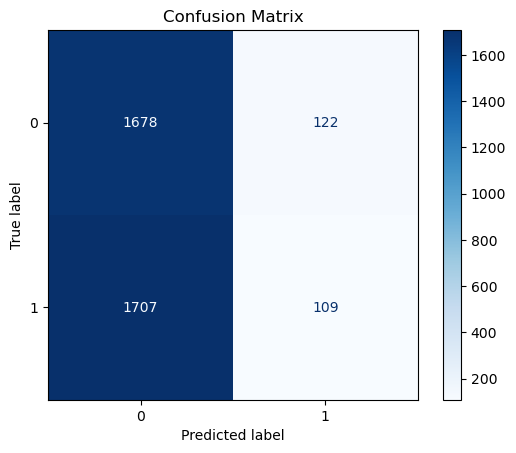

Precision: 0.4719
Recall: 0.0600
F1 Score: 0.1065


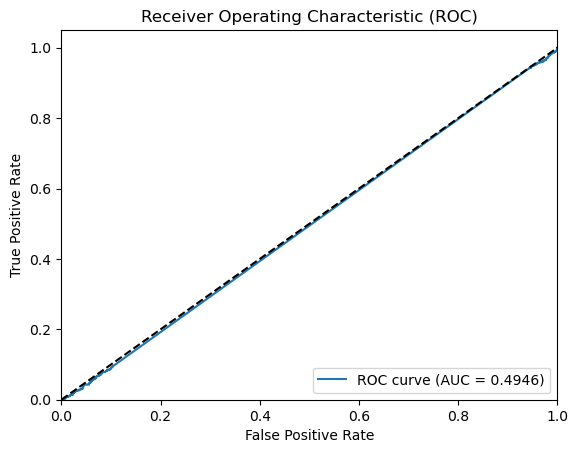

AUC: 0.4946


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve, auc

def evaluate_model_on_test(model, test_ds, test_steps, threshold=0.5):
    # Predict
    y_pred_probs = model.predict(test_ds, steps=test_steps)
    y_pred = (y_pred_probs > threshold).astype(int)
    
    # Get true labels
    y_true = []
    for (img, meta), label in test_ds.take(test_steps):
        y_true.append(label.numpy())
    y_true = np.concatenate(y_true, axis=0)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Precision, Recall, F1
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # random classifier line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"AUC: {roc_auc:.4f}")
batch_size = 32
num_test_images = 3647

test_steps = num_test_images // batch_size  # 113

evaluate_model_on_test(model_multi, final_test_ds, test_steps)


In [ ]:
# this model has no predictive power